**Imports**

In [5]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from sklearn import preprocessing
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

**Load Data**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() 

170508288/170498071 [==============================] - 2s 0us/step


**Normalize**

In [28]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train = x_train / 255.0  #range twn pixel = [0,255]
x_test = x_test / 255.0

**Reshape σε tuple διαστάσεων (60000,32\*32\*3)**

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test =np.reshape(x_test, (x_test.shape[0], -1))
print(x_train.shape)

**OPTIONAL:**

Μετατρέπουμε σε grayscale το training και το test sample για να μειωθούν οι διαστάσεις τους (πχ. το x_train απο (50000,32,32,3) σε (50000,32,32) , δηλαδή να αντικαταστήσουμε το RGB που θέλει 3 νούμερα με grayscale) ώστε να έχουμε καλύτερο runtime και ιδανικά παρόμοιες/ίδιες αποδόσεις

In [ ]:
# x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_train])
# x_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])
# print(x_train.shape)

# **AUTOENCODER**

**Model setup**

Κάνουμε define την αρχιτεκτονική του δικτύου (Dense/Convolutional)
*    τα layers
*    τους νευρώνες
*    το filter
*    το kernel size
*    το stride
*    τις activation functions τους
*    το initialization
*    το loss

**Dense AutoEncoder** (best results)

In [ ]:
#Dense

latent_dim = 512

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(latent_dim, activation='sigmoid'),
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(3072, activation='sigmoid'),
      tf.keras.layers.Reshape((32, 32, 3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics = ['accuracy'])

#autoencoder.encoder.summary()
#autoencoder.decoder.summary()

**Convolution-Dense AutoEncoder**

In [ ]:
# Conv-Dense

latent_dim = 512

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(64, 5, activation='relu',strides=2, input_shape=(32,32,3), padding= 'same'),
      tf.keras.layers.MaxPool2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation = 'sigmoid')
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((2,2,128)),
      tf.keras.layers.UpSampling2D(size=(2,2)),
      tf.keras.layers.Conv2DTranspose(32, 5,strides= 2, padding = 'same', activation="relu"),
      tf.keras.layers.UpSampling2D(size=(2,2)),
      tf.keras.layers.Conv2DTranspose(3, 5,strides= 2, padding = 'same', activation="sigmoid"),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics = ['accuracy'])


**Convolution-Deconvolution AutoEncoder**

In [ ]:
latent_dim = 512

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu',strides=2, input_shape=(32,32,3), padding= 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, 3, activation='relu',strides=2, padding= 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128, 3, activation='relu',strides=2, padding= 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(256, 3, activation='relu',strides=2, padding= 'same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(256, 3, activation='relu',strides=1, padding= 'same'),
      tf.keras.layers.BatchNormalization()
    ])
    self.decoder = tf.keras.Sequential([
      tf.keras.layers.Conv2DTranspose(256, 3,strides= 2, padding = 'same', activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2DTranspose(128, 3,strides= 2, padding = 'same', activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2DTranspose(64, 3,strides= 2, padding = 'same', activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2DTranspose(32, 3,strides= 2, padding = 'same', activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2DTranspose(3, 3,strides= 1, padding = 'same')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics = ['accuracy'])

**Feeding the model**

Define το batch size και τις εποχές εκπαίδευσης

In [ ]:
autoencoder.fit(x_train, x_train,    #apo x_train --- stoxos to x_train pali
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose = 2)

**Encoding our images**


In [ ]:
predicted = autoencoder.predict(x_test)
predEncodTest= autoencoder.encoder.predict(x_test)
predEncodTrain = autoencoder.encoder.predict(x_train)

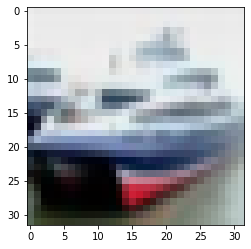

In [ ]:
plt.imshow(x_test[1])

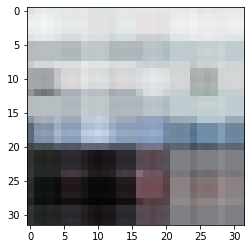

In [ ]:
plt.imshow(predicted[1])

In [ ]:
encoded_imgs_test = autoencoder.encoder(x_test).numpy()
decoded_imgs_test = autoencoder.decoder(encoded_imgs).numpy()

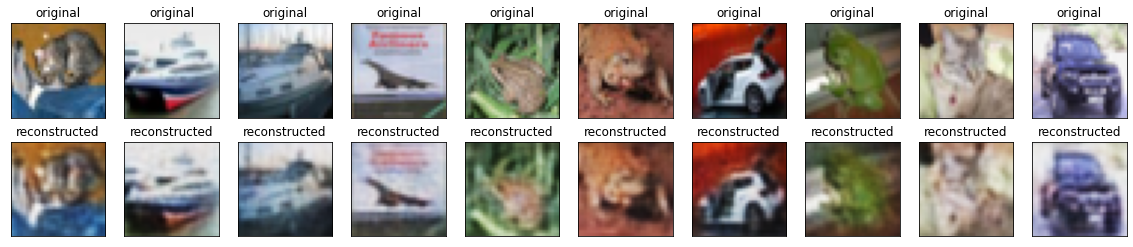

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs_test[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# **Adding noise**

In [ ]:
size = 32
channel = 3

# Adding noise mean = 0, std = 0.3
noise = 0.3

cifar_train_noise = x_train + noise * np.random.normal(0, 0.3, size=x_train.shape) 
cifar_test_noise = x_test + noise * np.random.normal(0, 0.3, size=x_test.shape)

cifar_train_noise = np.clip(cifar_train_noise, 0, 1)
cifar_test_noise = np.clip(cifar_test_noise, 0, 1)

**Visualize few training images with their noisy images**

In [ ]:
rows = 2 # defining no. of rows in figure
cols = 8 # defining no. of colums in figure

f = plt.figure(figsize=(2*cols,2*rows*2)) # defining a figure 

for i in range(rows):
    for j in range(cols): 
        f.add_subplot(rows*2,cols, (2*i*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(cifar_train_noise[i*cols + j]) 
        plt.axis("off")
        
    for j in range(cols): 
        f.add_subplot(rows*2,cols,((2*i+1)*cols)+(j+1)) # adding sub plot to figure on each iteration
        plt.imshow(x_train[i*cols + j]) 
        plt.axis("off")
        
f.suptitle("Sample Training Data",fontsize=18)
plt.savefig("Cifar-trian.png")

plt.show()

**Για να πετύχουμε το image denoising αρκεί να κάνουμε feed τις noisy εικόνες στα προηγούμενα μοντέλα και να βάλουμε ως στόχο το αρχικό dataset**

# **PCA**

In [31]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() 

In [32]:
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test =np.reshape(x_test, (x_test.shape[0], -1))
print(x_train.shape)

(50000, 3072)


**Normalize**

In [33]:
x_train = x_train /255.0
x_test = x_test /255.0

**Εφαρμόζουμε PCA κρατώντας το 95% του variance**

In [34]:
pca = PCA(n_components = 512)  #n_components = 0.95

In [35]:
pca.fit(x_train)

PCA(n_components=512)

In [21]:
print(len(pca.explained_variance_ratio_),sum(pca.explained_variance_ratio_)) #επιβεβαιώνουμε τα αποτελέσματα

512 0.9839343231496908


**Μετατρέπουμε τα δεδομένα μας σύμφωνα με το PCA**

In [19]:
# pca_data = pca.transform(x_train)
# pca_data_test = pca.transform(x_test)

In [36]:
mu = np.mean(x_train, axis=0)

nComp = 512

reconstructed_pca = np.dot(pca.transform(x_train)[:,:nComp], pca.components_[:nComp,:])
reconstructed_pca += mu

In [37]:
gen_images = np.reshape(reconstructed_pca,(50000,32,32,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


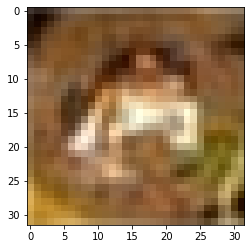

In [38]:
plt.imshow(gen_images[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


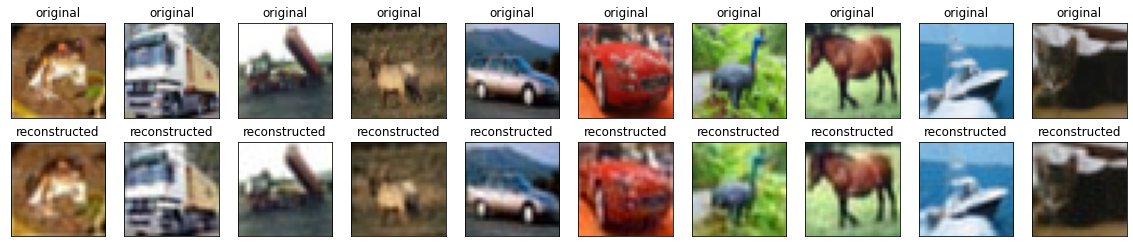

In [39]:
n = 10
plt.figure(figsize=(20, 4))
x_train = np.reshape(x_train, (50000,32,32,3))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_train[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(gen_images[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# **Variational AutoEncoders**

Sampling layer. Χρησιμοποιεί τις τιμές z_mean και z_log_var που παίρνει και απο το δίκτυο για να κάνει sample το z

In [8]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Χρησιμοποιούμε το functional API γιατί είναι πιο εύκολο να κάνουμε modify όλες τις πλευρές του network μας όπως να προσθέσουμε layers κλπ σε αντίθεση με ένα Object Oriented μοντέλο

In [30]:
#ENCODER with functional API
latent_dim = 2

encoder_inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = tf.keras.layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 32)   896         ['input_6[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 4096)         0           ['conv2d_3[0][0]']               
                                                                                            

In [31]:
#DECODER with functional API
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(8 * 8 * 32, activation="relu")(latent_inputs)
x = tf.keras.layers.Reshape((8, 8, 32))(x)
x = tf.keras.layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = tf.keras.layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 2048)              6144      
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 32)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 64)       18496     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 32, 32, 3)        867 

In [32]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):  #metrics to keep track of
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data) #(encode)we sample the z
            reconstruction = self.decoder(z) #we decode it
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.mean_squared_error(data, reconstruction), axis=(1, 2)
                )
            )
            print(reconstruction_loss)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))  #creating the KL divergence loss
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            print(kl_loss)
            total_loss = reconstruction_loss + kl_loss  #adding it, to create the final loss we need to minimize
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))  #applying gradients and updating everything
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Θα μπορούσαμε να είχαμε εισάγει το παρακάτω function για να αποφύγουμε όλον αυτόν τον κώδικα αλλά για κάποιο λόγο δεν κάνει σωστά train οπότε έπρεπε το κάνουμε from scratch


In [ ]:
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

In [27]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data() 

In [33]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=512)

Epoch 1/10
Tensor("Mean_1:0", shape=(), dtype=float32)
Tensor("Mean_2:0", shape=(), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32)
Tensor("Mean_2:0", shape=(), dtype=float32)
98/98 [==============================] - 8s 67ms/step - loss: 62.9984 - reconstruction_loss: 59.2735 - kl_loss: 0.7970
Epoch 2/10
98/98 [==============================] - 7s 67ms/step - loss: 49.5213 - reconstruction_loss: 43.5596 - kl_loss: 2.8057
Epoch 3/10
98/98 [==============================] - 7s 67ms/step - loss: 42.7999 - reconstruction_loss: 39.2893 - kl_loss: 3.2231
Epoch 4/10
98/98 [==============================] - 7s 67ms/step - loss: 42.2841 - reconstruction_loss: 39.0790 - kl_loss: 3.2142
Epoch 5/10
98/98 [==============================] - 7s 67ms/step - loss: 42.2611 - reconstruction_loss: 38.9349 - kl_loss: 3.2170
Epoch 6/10
98/98 [==============================] - 7s 67ms/step - loss: 42.1479 - reconstruction_loss: 38.8778 - kl_loss: 3.1922
Epoch 7/10
98/98 [==========================

**Object oriented Dense VAE**

In [38]:
import tensorflow as tf
from tensorflow.keras import layers


class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
    def __init__(self, latent_dim=32, intermediate_dim=64, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(layers.Layer):
    def __init__(self, original_dim, intermediate_dim=64, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)


class VariationalAutoEncoder(tf.keras.Model):
    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        latent_dim=32,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

In [40]:
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test =np.reshape(x_test, (x_test.shape[0], -1))
print(x_train.shape)

(50000, 3072)


In [41]:
vae = VariationalAutoEncoder(3072, 1024, 2)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer, loss= tf.keras.losses.MeanSquaredError(), metrics = 'accuracy')
vae.fit(x_train, x_train, epochs=2, batch_size=512, shuffle = True, verbose = 2, validation_data = (x_test, x_test))

Epoch 1/2
98/98 - 4s - loss: 43.5133 - accuracy: 3.0000e-04 - val_loss: 0.3699 - val_accuracy: 6.0000e-04 - 4s/epoch - 36ms/step
Epoch 2/2
98/98 - 2s - loss: 0.0950 - accuracy: 4.2000e-04 - val_loss: 0.0719 - val_accuracy: 4.0000e-04 - 2s/epoch - 20ms/step
